In [31]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import bz2
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.stats import rankdata  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206296 entries, 0 to 206295
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   tournamentId        206296 non-null  int32         
 1   tournament_name     206296 non-null  object        
 2   type                206296 non-null  object        
 3   division            206296 non-null  object        
 4   divisionId          206296 non-null  object        
 5   gender              206296 non-null  object        
 6   age_type            206296 non-null  object        
 7   match_id            206296 non-null  int32         
 8   roundNumber         206296 non-null  int32         
 9   matchNumber         206296 non-null  int32         
 10  matchWinner         206296 non-null  object        
 11  series_number       206296 non-null  int32         
 12  match_type          206296 non-null  object        
 13  isMatch             206296 no

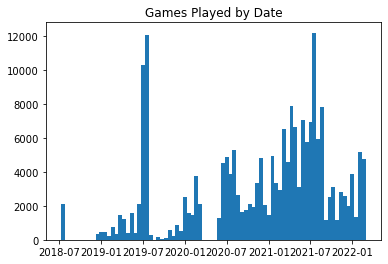

In [32]:


#Pickle in vball data
with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Move to data frame
df_vball=pd.DataFrame(vball)

df_vball.info()
df_vball.head()

#Look at game density over time before time filtering
plt.hist(df_vball[['datetime']],bins=80)
plt.title('Games Played by Date')
plt.show()


In [33]:
with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/new_vball_game_data_alt.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball_new = pickle.load(uncompressed)

#Create TrueSkill Through Time Implementation
vball_new.shape[0]/4

9667.0

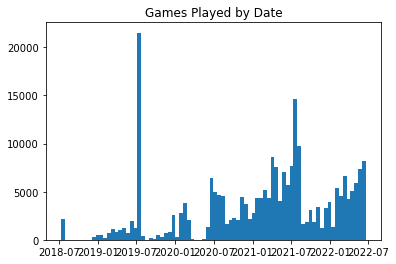

In [40]:
vball_new_clean=vball_new[(vball_new['datetime'] >= max(vball['datetime']))]
new_game_start_index=int(len(vball)/4)
vball_all=np.concatenate((vball, vball_new_clean))
vball_all_df=pd.DataFrame(vball_all)

#Look at game density over time before time filtering
plt.hist(vball_all_df[['datetime']],bins=80)
plt.title('Games Played by Date')
plt.show()

In [35]:
vball_all_df.iloc[new_game_start_index+4,:]

tournamentId                                                        929
tournament_name       p1440 Southern Championship (Junior Summer Cha...
type                                                              Local
division                                                            16U
divisionId                                                            7
gender                                                            Girls
age_type                                                        Juniors
match_id                                                           6090
roundNumber                                                           3
matchNumber                                                         251
matchWinner                                                        Away
series_number                                                         1
match_type                                                      Bracket
isMatch                                                         

In [36]:
def network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
  pred_date_check=False
  result_holder=[]
  loop=1
  pred_count=0
  while pred_date_check==False:
    if loop==1:
      reference_date=train_start_date
    if loop>1:
      reference_date=pred_end_date-timedelta(days=training_period_days)
    
    loop+=1
    #filter for train_start_date
    ref_end_date=reference_date+timedelta(days=training_period_days)
    df_recent=dataset.loc[(dataset['datetime'] >= reference_date) & (dataset['datetime'] < ref_end_date)]
    
    #Filter out games with no score
    df_recent=df_recent[(df_recent.ignored_score==False) & (df_recent.incomplete_score==False)]
    df_recent=df_recent.reset_index()

    #Get all opponents in one column for group by
    df_recent_dup=df_recent.copy()
    df_recent_dup.opponent1_id=df_recent_dup.opponent2_id

    df_long=df_recent.copy()
    df_long=df_long.append(df_recent_dup, ignore_index = True)

    # #Group players by points played against each opponent which can be used to understand confidence of rating
    # grp_pts_played=df_long.groupby(['player_id','opponent1_id'])["winning_score"].sum()

    #Group players by pct points won average which can be used to understand who is better
    grp_pct_pts_won=df_long.groupby(['player_id','opponent1_id'])["pct_points_won"].mean()

    #Create unique player list and set up empty matrices
    player_list=sorted(list(df_recent['player_id'].unique()))
    # points_matrix=np.zeros((len(player_list),len(player_list)))
    pct_points_matrix=np.zeros((len(player_list),len(player_list)))

    #Create dictionary of sum of points played and avg pct points won
    # dict_pts_played=dict(grp_pts_played)
    dict_pct_pts_won=dict(grp_pct_pts_won)
    player_order_dict={k:v for v,k in enumerate(player_list)}

    # #Fill points matrix (from row to column id)
    # for k,v in dict_pts_played.items():
    #   points_matrix[player_order_dict[k[0]],player_order_dict[k[1]]]=v

    #Fill pct points won matrix (from row to column id)
    #Using 1-v so that the edges point to the better team
    for k,v in dict_pct_pts_won.items():
      pct_points_matrix[player_order_dict[k[0]],player_order_dict[k[1]]]=1-v

    #Random Walk
    holder=[]
    restart=True
    iterations=rw_iterations
    for i in range(iterations):
      if restart==True:
        random.seed(i)
        start_row = random.randint(0,len(player_list)-1)
        holder.append(start_row)
        new_row = random.choices(list(range(len(player_list))), weights=list(pct_points_matrix[start_row,:]), k=1)
        restart=False
      else:
        new_row = random.choices(list(range(len(player_list))), weights=list(pct_points_matrix[new_row[0],:]), k=1)  
      
      holder.append(new_row[0])
      
      random.seed(i)
      random_val=random.randint(1,10000)
      if random_val<=round(reset_probability*10000,0):
        restart=True
      
      # if i%(iterations-1)==0 and i!=0:
      #   print('model trained')

    ratings={k: v for k, v in sorted(Counter(holder).items(), key=lambda item: item[1],reverse=True)}
    rankings=dict(zip(ratings.keys(), rankdata([-i for i in ratings.values()], method='average')))

    pred_start_date=ref_end_date
    pred_end_date=pred_start_date+timedelta(days=prediction_period_days)
    df_pred=dataset.loc[(dataset['datetime'] >= pred_start_date) & (dataset['datetime'] < pred_end_date),['player_id','teammate_id','opponent1_id','opponent2_id']].to_numpy()
    df_target=dataset.loc[(dataset['datetime'] >= pred_start_date) & (dataset['datetime'] < pred_end_date),['win']].to_numpy()
      
    df_pred=df_pred[::4]
    df_target=df_target[::4]
  
    for i,row in enumerate(df_pred):
      if any(x in rankings for x in row[[0,1]]) and any(x in rankings for x in row[[0,1]]):
          team1=(rankings.get(row[0],row[1])+rankings.get(row[1],row[0]))/2
          team2=(rankings.get(row[2],row[3])+rankings.get(row[3],row[2]))/2
          if team1==team2:
              result_holder.append(-1) #predicted tie
          elif min(team1,team2)==team1 and df_target[i]==True:
              result_holder.append(1) #correct prediction
          else:
              result_holder.append(0) #incorrect prediction
      else:
        result_holder.append(-2) #one team was completely unranked
        
        

    if train_end_date==None:
      if pred_end_date>max(dataset.datetime):
        pred_date_check=True
    else:
      if pred_end_date>train_end_date:
        pred_date_check=True
  
    pred_count+=len(df_pred)
    # print(len(df_recent))
    # print(reference_date)
    # print(ref_end_date)
    # print(len(df_pred))
    # print(pred_start_date)
    print('Model updated through',pred_end_date)
    # print(pred_count)
    

  print(Counter(result_holder))
  if Counter(result_holder)[0]==0:
    print('Error no values captured')
  else:
    print('accuracy:',Counter(result_holder)[1]/(Counter(result_holder)[0]+Counter(result_holder)[1]))

In [39]:
%%time

#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
train_period=90
start_date=datetime(2022, 3, 5)-timedelta(days=train_period)
network_model(vball_all_df,start_date,train_period,30,70000,.05)

Model updated through 2022-04-04 00:00:00
Model updated through 2022-05-04 00:00:00
Model updated through 2022-06-03 00:00:00
Model updated through 2022-07-03 00:00:00
Counter({-2: 8555, 1: 512, 0: 251})
accuracy: 0.6710353866317169
CPU times: user 1min 28s, sys: 199 ms, total: 1min 28s
Wall time: 1min 28s


In [37]:
%%time

#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
train_period=180
start_date=datetime(2022, 3, 5)-timedelta(days=train_period)
network_model(vball_all_df,start_date,train_period,30,70000,.05)

Model updated through 2022-04-04 00:00:00
Model updated through 2022-05-04 00:00:00
Model updated through 2022-06-03 00:00:00
Model updated through 2022-07-03 00:00:00
Counter({-2: 7893, 1: 955, 0: 470})
accuracy: 0.6701754385964912
CPU times: user 1min 59s, sys: 325 ms, total: 1min 59s
Wall time: 1min 59s


In [38]:
%%time

#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
train_period=365
start_date=datetime(2022, 3, 5)-timedelta(days=train_period)
network_model(vball_all_df,start_date,train_period,30,70000,.05)

Model updated through 2022-04-04 00:00:00
Model updated through 2022-05-04 00:00:00
Model updated through 2022-06-03 00:00:00
Model updated through 2022-07-03 00:00:00
Counter({-2: 5766, 1: 2177, 0: 1375})
accuracy: 0.6128941441441441
CPU times: user 4min 30s, sys: 1.41 s, total: 4min 31s
Wall time: 4min 33s


In [ ]:
list(set(vball['player_id']))

In [ ]:
# Previous Best
# Model updated through 2022-03-23 00:00:00
# Counter({-2: 40575, 1: 6325, 0: 3596, -1: 1})
# accuracy: 0.6375365386553775

# how rankings could impact